This example illustrates fitting and comparing several Machine Learning algorithms for classifying the binary target in the         
HMEQ data set.

The steps include:                              
                                                                      
1. PREPARE AND EXPLORE  
  a) Check data is loaded into CAS                               
<br>                                                                      
2. PERFORM SUPERVISED LEARNING  
  a) Fit a model using a Random Forest  
  b) Fit a model using Gradient Boosting  
  c) Fit a model using a Neural Network  
  d) Fit a model using a Support Vector Machine                       
<br>                                                                      
3. EVALUATE AND IMPLEMENT  
  a) Score the data  
  b) Assess model performance  
  c) Generate ROC and Lift charts                                  

### Import packages

In [1]:
from swat import *
from pprint import pprint
from matplotlib import pyplot as plt
import pandas as pd
from swat.render import render_html
%matplotlib inline

### CAS Server connection details

In [2]:
cashost='sasserver.demo.sas.com'
casport=5570
casauth='~/.authinfo'
indata_dir="data"
indata="hmeq"

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo="~/.authinfo", caslib="casuser")

### Import action sets

In [4]:
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="decisionTree")
sess.loadactionset(actionset="neuralNet")
sess.loadactionset(actionset="svm")
sess.loadactionset(actionset="astore")
sess.loadactionset(actionset="percentile")

NOTE: Added action set 'dataStep'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000135s, mem: 0.0281mb

### Set variables for input data

In [5]:
target          = "bad"
class_inputs    = ["reason", "job"]
class_vars      = [target] + class_inputs
interval_inputs = ["im_clage", "clno", "im_debtinc", "loan", "mortdue", "value", "im_yoj", "im_ninq", "derog", "im_delinq"]
all_inputs      = interval_inputs + class_inputs

### Load data into CAS if needed

In [6]:
if not sess.table.tableExists(table=indata).exists:
    sess.loadTable(caslib="casuser", path=indata_dir+"/"+indata+".sas7bdat", casout={"name":indata})

NOTE: Cloud Analytic Services made the file data/hmeq.sas7bdat available as table HMEQ in caslib CASUSER(viyauser).


### Explore and Impute missing values

#### View first 5 observations from the data set

In [7]:
sess.fetch(table='hmeq', to=5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


#### Explore data and plot missing values

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.503622 seconds.
----------------------------------Data Summary----------------------------------


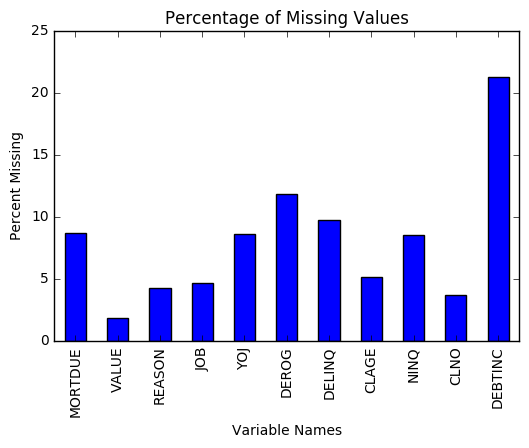

In [8]:
sess.cardinality.summarize(
  table={"name":indata}, 
  cardinality={"name":"data_card", "replace":True}
)

tbl_data_card=sess.CASTable('data_card')
tbl_data_card.where='_NMISS_>0'
print("Data Summary".center(80, '-')) # print title
tbl_data_card.fetch() # print obs

tbl_data_card.vars=['_VARNAME_', '_NMISS_', '_NOBS_']
allRows=20000  # Assuming max rows in data_card table is <= 20,000
df_data_card=tbl_data_card.fetch(to=allRows)['Fetch']
df_data_card['PERCENT_MISSING']=(df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100

tbl_forplot=pd.Series(list(df_data_card['PERCENT_MISSING']), index=list(df_data_card['_VARNAME_']))
ax=tbl_forplot.plot(
  kind='bar', 
  title='Percentage of Missing Values'
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names')

#### Impute missing values

In [9]:
sess.dataPreprocess.transform(
  table={"name":indata},
  casOut={"name":"hmeq_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"clage"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"delinq"}},
    {"impute":{"method":"RANDOM"}, "inputs":{"ninq"}},
    {"impute":{"method":"VALUE", "valuesContinuous":{50, 100}}, "inputs":{"debtinc", "yoj"}}
  ]
)

[TransInfo]

 Transformation Requests for HMEQ
 
   ActualName  NTransVars ImputeMethod          Seed
 0       _TR1           1         Mean           NaN
 1       _TR2           1       Median           NaN
 2       _TR3           1       Random  1.801404e+09
 3       _TR4           2        Value           NaN

[VarTransInfo]

 Variable Transformation Information for HMEQ
 
   Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous
 0    CLAGE             IM    IM_CLAGE  5652    308              179.766275
 1  DEBTINC             IM  IM_DEBTINC  4693   1267               50.000000
 2   DELINQ             IM   IM_DELINQ  5380    580                0.000000
 3     NINQ             IM     IM_NINQ  5450    510                     NaN
 4      YOJ             IM      IM_YOJ  5445    515              100.000000

[OutputCasTables]

               casLib          Name  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_prepped  5960       18   
 
                                             casTable  
 0  CASTable('hmeq_prepped', caslib='CASUSER(viyau...  

+ Elapsed: 0.0232s, user: 0.02s, sys: 0.005s, mem: 9.52mb

### Partition data into Training and Validation

In [10]:
sess.sampling.stratified(
  table={"name":"hmeq_prepped", "groupBy":"bad"},
  output={"casOut":{"name":"hmeq_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Using SEED=1499996667 for sampling.


[outputSize]

 {'outputNObs': 5960.0, 'outputNVars': 19}

[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4771   3340
 1        1             1  1189    832

[OutputCasTables]

               casLib       Name Label  Rows  Columns  \
 0  CASUSER(viyauser)  hmeq_part        5960       19   
 
                                             casTable  
 0  CASTable('hmeq_part', caslib='CASUSER(viyauser)')  

+ Elapsed: 0.0158s, user: 0.01s, sys: 0.007s, mem: 9.72mb

### Random Forest

In [11]:
rf = sess.decisionTree.forestTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  nTree=50,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAINRATIO",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  OOB=True,
  casOut={"name":"forest_model", "replace":True}
)

# Output model statistics
render_html(rf)

# Score 
sess.decisionTree.forestScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"bad", "_partind_"},
  vote="PROB"
)

# Create p_bad0 and p_bad1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="""data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_bad1=_rf_predp_; 
    p_bad0=1-p_bad1; end; if _rf_predname_=0 then do; p_bad0=_rf_predp_; p_bad1=1-p_bad0; end; run;"""
)

Forest for HMEQ_PART 
 Descr 
 Value 
 
 
 Number of Trees 50 
 Number of Selected Variables (M) 4 
 Random Number Seed 0 
 Bootstrap Percentage (%) 63.212055882 
 Number of Bins 20 
 Number of Variables 12 
 Confidence Level for Pruning 0.25 
 Max Number of Tree Nodes 339 
 Min Number of Tree Nodes 153 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 21 
 Min Number of Levels 21 
 Max Number of Leaves 170 
 Min Number of Leaves 77 
 Maximum Size of Leaves 1317 
 Minimum Size of Leaves 5 
 Out-of-Bag MCR (%) 10.21093001 
 
 
 
 
 OOB Error With Forest Analytics for HMEQ_PART 
 TreeID 
 Trees 
 NLeaves 
 MCR 
 LogLoss 
 ASE 
 RASE 
 MAXAE 
 
 
 0 1 130 0.1252806466 1.106978365 0.1027731335 0.320582491 1 
 1 2 270 0.1252686521 1.1385294391 0.1775778334 0.4213998497 1 
 2 3 412 0.119763695 1.0530493458 0.2194001719 0.4684017206 1 
 3 4 522 0.1099039919 0.9810613388 0.245609313 0.4955898637 1 
 4 5 608 0.1058045555 0.9622344055 0.2667304762 0.5164595591 1 
 5 6 703 0.107696031 0.9245739017 0.2774935677 0.5267765824 1 
 6 7 797 0.1093975904 0.9060851313 0.2867532091 0.5354934259 1 
 7 8 909 0.1094012984 0.9039442743 0.2927551267 0.5410685046 1 
 8 9 1036 0.1067914567 0.890320849 0.2966258389 0.544633674 1 
 9 10 1145 0.1055155875 0.8838757366 0.2984030839 0.5462628341 1 
 10 11 1238 0.1079136691 0.8850833247 0.302984997 0.5504407298 1 
 11 12 1361 0.1074082954 0.8800229868 0.3051036267 0.5523618621 1 
 12 13 1488 0.1081275474 0.878298958 0.306750375 0.5538504988 1 
 13 14 1574 0.1071428571 0.8747672665 0.3077421446 0.5547451168 1 
 14 15 1714 0.1073825503 0.8772296158 0.3101245839 0.5568883047 1 
 15 16 1851 0.1071428571 0.8791985393 0.3110775933 0.5577433041 1 
 16 17 1950 0.1064237776 0.8770080249 0.3109094718 0.5575925679 1 
 17 18 2034 0.1054650048 0.8784643318 0.312007937 0.5585767065 1 
 18 19 2160 0.1042665388 0.8791835037 0.3129465162 0.559416228 1 
 19 20 2271 0.104506232 0.8800070469 0.3136145832 0.5600130206 1 
 20 21 2402 0.1047459252 0.879884878 0.3139190734 0.5602848146 1 
 21 22 2541 0.1016299137 0.8747690502 0.3138372427 0.5602117838 0.9968466784 
 22 23 2669 0.1025886865 0.8748967592 0.3141658899 0.5605050311 0.9966138996 
 23 24 2790 0.1021093001 0.8751370847 0.314376611 0.5606929739 0.9967549871 
 24 25 2909 0.1028283797 0.8754709296 0.3149615844 0.5612143836 0.9967549871 
 25 26 2986 0.1030680729 0.8753063366 0.3151305046 0.5613648587 0.9965212445 
 26 27 3110 0.1013902205 0.8752056271 0.3153265473 0.5615394441 0.9954481833 
 27 28 3224 0.1011505273 0.8767088409 0.3160207301 0.5621572112 0.9954481833 
 28 29 3341 0.1016299137 0.8775358603 0.3166410871 0.5627087054 0.9949938565 
 29 30 3441 0.1018696069 0.8788150601 0.317144832 0.5631561347 0.9949938565 
 30 31 3593 0.1001917546 0.8793449197 0.317553368 0.5635187379 0.9953168335 
 31 32 3730 0.1004314477 0.8800712302 0.3179511417 0.5638715649 0.9953168335 
 32 33 3847 0.1004314477 0.8797710955 0.3180082893 0.5639222369 0.9956006617 
 33 34 3979 0.0992329818 0.8796147619 0.3181146262 0.5640165123 0.9956006617 
 34 35 4098 0.1004314477 0.8802714835 0.3183856816 0.5642567515 0.9958520525 
 35 36 4216 0.0997123682 0.8792464561 0.3182329978 0.5641214389 0.9958520525 
 36 37 4311 0.099472675 0.8798153461 0.318336414 0.5642130927 0.9958520525 
 37 38 4398 0.0997123682 0.8803517672 0.3186128531 0.5644580171 0.9958520525 
 38 39 4485 0.0999520614 0.8808482425 0.3188273922 0.564648025 0.9958520525 
 39 40 4616 0.1004314477 0.8815972555 0.3194436158 0.5651934322 0.9962243471 
 40 41 4736 0.1013902205 0.8813638568 0.3194691538 0.565216024 0.9963164362 
 41 42 4836 0.1018696069 0.8822551355 0.3198691855 0.5655697884 0.9952389105 
 42 43 5006 0.1023489933 0.88246664 0.3200769319 0.5657534197 0.9952389105 
 43 44 5116 0.1021093001 0.8830274217 0.3203726937 0.5660147469 0.9954553237 
 44 45 5194 0.1018696069 0.8832054231 0.3204396098 0.5660738554 0.9954553237 
 45 46 5295 0.1009108341 0.8832058873 0.3206050765 0.5662199895 0.9954553237 
 46 47 5418 0.

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:109
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:109  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_rf,5960,7,"CASTable('_scored_rf', caslib='CASUSER(viyause..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_rf,5960,9,"CASTable('_scored_rf', caslib='CASUSER(viyause..."


### Gradient Boosting

In [12]:
gb = sess.decisionTree.gbtreeTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  nTree=10,
  nBins=20,
  maxLevel=6,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"gb_model", "replace":True}
)

# Output model statistics
render_html(gb)

# Score 
sess.decisionTree.gbtreeScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"gb_model"},
  casOut={"name":"_scored_gb", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _gbt_predp_ is the probability of event in _gbt_predname_
sess.dataStep.runCode(
  code="""data _scored_gb; set _scored_gb; if _gbt_predname_=1 then do; p_bad1=_gbt_predp_; 
    p_bad0=1-p_bad1; end; if _gbt_predname_=0 then do; p_bad0=_gbt_predp_; p_bad1=1-p_bad0; end; run;"""
)

Gradient Boosting Tree for HMEQ_PART 
 Descr 
 Value 
 
 
 Number of Trees 10 
 Distribution 2 
 Learning Rate 0.1 
 Subsampling Rate 0.5 
 Number of Selected Variables (M) 12 
 Number of Bins 20 
 Number of Variables 12 
 Max Number of Tree Nodes 57 
 Min Number of Tree Nodes 41 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 6 
 Min Number of Levels 6 
 Max Number of Leaves 29 
 Min Number of Leaves 21 
 Maximum Size of Leaves 1275 
 Minimum Size of Leaves 5 
 Random Number Seed 0 
 
 
 
 
 Decision Tree for HMEQ_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 IM_DEBTINC 123.78553304 82.222543725 
 IM_DELINQ 25.46917349 8.6959511039 
 DEROG 17.42320236 7.560827089 
 VALUE 16.383712794 4.1400498727 
 CLNO 12.453265614 4.4806537442 
 IM_CLAGE 11.881738001 4.8971443663 
 JOB 6.3790688736 3.3284188388 
 MORTDUE 5.6496657413 3.7359203793 
 LOAN 5.5862217038 3.1343958253 
 IM_NINQ 3.3986382417 1.3626054059 
 IM_YOJ 3.3463510342 2.4569997578 
 REASON 0.9122232439 0.2941004147 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(viyauser) gb_model 462 32 CASTable('gb_model', caslib='CASUSER(viyauser)')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:111
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:111  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_gb,5960,6,"CASTable('_scored_gb', caslib='CASUSER(viyause..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_gb,5960,8,"CASTable('_scored_gb', caslib='CASUSER(viyause..."


### Neural Network

In [13]:
nn = sess.neuralNet.annTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  validTable={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='0'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  hiddens={2},
  acts={"TANH"},
  combs={"LINEAR"},
  targetAct="SOFTMAX",
  errorFunc="ENTROPY",
  std="MIDRANGE",
  randDist="UNIFORM",
  scaleInit=1,
  nloOpts={
    "optmlOpt":{"maxIters":250, "fConv":1e-10}, 
    "lbfgsOpt":{"numCorrections":6},
    "printOpt":{"printLevel":"printDetail"},
    "validate":{"frequency":1}
  },
  casOut={"name":"nnet_model", "replace":True}
)

# Output model statistics
render_html(nn)

# Score 
sess.neuralNet.annScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"nnet_model"},
  casOut={"name":"_scored_nn", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _nn_predp_ is the probability of event in _nn_predname_
sess.dataStep.runCode(
  code="""data _scored_nn; set _scored_nn; if _nn_predname_=1 then do; p_bad1=_nn_predp_; 
    p_bad0=1-p_bad1; end; if _nn_predname_=0 then do; p_bad0=_nn_predp_; p_bad1=1-p_bad0; end; run;"""
)

Iteration History 
 Progress 
 Objective 
 Loss 
 Validation Error 
 Step Size 
 L1 Norm 
 L2 Norm 
 MAX Norm 
 Gradient Norm 
 
 
 1 2.7562840323 2.7562840323 0.297277937 0 1.4608019719 0.4392592493 0.3899743444 1.755897424 
 2 2.0085267249 2.0085267249 0.2034383954 0.5695093497 3.7832408789 0.8331986995 0.405730811 0.2993527629 
 3 1.978990508 1.978990508 0.2034383954 1 4.1801319637 0.9382303456 0.5367389813 0.0423185123 
 4 1.9779644314 1.9779644314 0.2034383954 1 4.1486263016 0.9326928267 0.5301685754 0.0392072139 
 5 1.9631363276 1.9631363276 0.2034383954 1 4.7546014889 0.9813098208 0.4643664416 0.1870412347 
 6 1.9507899352 1.9507899352 0.2034383954 0.1443711571 5.8439897543 1.18166395 0.4372337803 0.3362972896 
 7 1.93624548 1.93624548 0.2034383954 0.369060466 7.6364137295 1.6088536104 0.671848151 0.5316201719 
 8 1.9066878962 1.9066878962 0.1998567335 1 9.8481464632 2.1281315499 0.9313722425 0.6121302448 
 9 1.790428691 1.790428691 0.1833810888 1 19.48673005 4.2374430071 1.9553568486 0.5713979399 
 10 1.7320644088 1.7320644088 0.1819484241 1 27.094612701 6.0386034197 2.9009300499 0.2677546445 
 11 1.7133363167 1.7133363167 0.1805157593 1 26.057133957 5.7788110613 2.7564954539 0.1748817587 
 12 1.6937229945 1.6937229945 0.1769340974 1 25.919431578 5.7274066157 2.7093789338 0.2552107827 
 13 1.6745284909 1.6745284909 0.1797994269 1 25.488874562 5.6283812847 2.6680492297 0.2487696786 
 14 1.6353830891 1.6353830891 0.1776504298 1 21.005404609 4.6809392395 2.214929428 0.1802397759 
 15 1.6008290133 1.6008290133 0.1769340974 1 26.273507879 5.8669264929 2.8588957488 0.1847905708 
 16 1.5776958593 1.5776958593 0.1769340974 1 26.298781992 5.8699662919 2.8941926504 0.0904064432 
 17 1.5468861023 1.5468861023 0.1661891117 1 24.210857247 5.4731398314 2.6936113 0.2857161862 
 18 1.5252918646 1.5252918646 0.1661891117 0.4650201248 21.902386301 5.0373773318 2.4295569867 0.3321729238 
 19 1.5022922652 1.5022922652 0.1669054441 1 21.577392266 5.1580943451 2.3292424868 0.1824586709 
 20 1.4928716208 1.4928716208 0.1669054441 1 27.447386566 6.4976039156 3.008756022 0.5326328675 
 21 1.4579063421 1.4579063421 0.1618911175 1 25.823038588 6.1119141989 2.7876260898 0.0944123019 
 22 1.4512558251 1.4512558251 0.1618911175 1 24.851744067 5.9467268984 2.7443193357 0.1641097454 
 23 1.4444292829 1.4444292829 0.1618911175 1 25.250495292 6.0720403188 2.8480164181 0.1144220576 
 24 1.4189889538 1.4189889538 0.1618911175 1 27.365943615 6.7126298747 3.3960641062 0.1192545512 
 25 1.4031119594 1.4031119594 0.1618911175 1 27.134044668 6.7083771505 3.673360647 0.5568986016 
 26 1.3848956599 1.3848956599 0.1561604585 1 29.589483741 7.2872497054 4.1304238631 0.208979603 
 27 1.3754684706 1.3754684706 0.1561604585 1 28.864586772 7.117671581 3.9460847693 0.1571881009 
 28 1.3323340665 1.3323340665 0.1446991404 1 28.586844332 7.0878952818 4.0618772498 0.1679228385 
 29 1.3110978769 1.3110978769 0.1368194842 1 32.588483399 8.0698876912 4.8768295808 0.4887121651 
 30 1.2827819199 1.2827819199 0.1346704871 1 32.185968805 7.9465592328 4.7740977937 0.1652867764 
 31 1.27176945 1.27176945 0.13252149 1 34.243109847 8.4616595441 5.1094265546 0.1282658291 
 32 1.2590363509 1.2590363509 0.1289398281 1 35.82468184 8.9408255018 5.4831988661 0.5897551687 
 33 1.2506055053 1.2506055053 0.1289398281 1 36.477479449 9.092790039 5.6149265127 0.254927644 
 34 1.2468353439 1.2468353439 0.1296561605 1 35.765196525 8.9176724609 5.4771639562 0.0851027482 
 35 1.2457353425 1.2457353425 0.1296561605 1 35.674025936 8.9037484736 5.4700538517 0.0804166502 
 36 1.2387788654 1.2387788654 0.1303724928 1 35.307922814 8.8769755903 5.4794796117 0.1709453172 
 37 1.2317177125 1.2317177125 0.1282234957 1 35.125310928 8.905512191 5.5421603147 0.2262431121 
 38 1.2242074233 1.2242074233 0.1282234957 1 35.366078453 9.0423448194 5.6928322594 0.1548439872 
 39 1.2167607442 1.2167607442 0.1253581662 1 35.70720052 9.2026088704 5.8594426913 0.0697135886 
 40 1.2102380279 1.2102380279 0.1224928367 1 36

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:109
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:109  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_nn,5960,4,"CASTable('_scored_nn', caslib='CASUSER(viyause..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(viyauser),_scored_nn,5960,6,"CASTable('_scored_nn', caslib='CASUSER(viyause..."


### Support Vector Machine

In [14]:
sv = sess.svm.svmTrain(
  table={
    "name":"hmeq_part", 
    "where":"_partind_=1"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  kernel="POLYNOMIAL",
  degree=2,
  id={"bad", "_partind_"},
  savestate={"name":"svm_astore_model", "replace":True}
)

# Output model statistics
render_html(sv)

# Score using ASTORE
sess.astore.score(
  table={"name":"hmeq_part"},
  rstore={"name":"svm_astore_model"},
  out={"name":"_scored_svm", "replace":True}
)

NOTE: SVM training is activated.
NOTE: Wrote 10261 bytes to the savestate file svm_astore_model.


Model Information 
 Descr 
 Value 
 
 
 Task Type C_CLAS 
 Optimization Technique Interior Point 
 Scale YES 
 Kernel Function Polynomial 
 Kernel Degree 2 
 Penalty Method C 
 Penalty Parameter 1 
 Maximum Iterations 25 
 Tolerance 1e-06 
 
 
 
 
 Observations 
 Descr 
 N 
 
 
 Number of Observations Read 4172 
 Number of Observations Used 3213 
 
 
 
 
 Training Results 
 Descr 
 Value 
 
 
 Inner Product of Weights 128.11676406 
 Bias -1.904893648 
 Total Slack (Constraint Violations) 851.28724108 
 Norm of Longest Vector 5.5727083045 
 Number of Support Vectors 1018 
 Number of Support Vectors on Margin 936 
 Maximum F 12.113050234 
 Minimum F -4.306941277 
 Number of Effects 12 
 Columns in Data Matrix 18 
 Columns in Kernel Matrix 190 
 
 
 
 
 Iteration History 
 Iteration 
 Complementarity 
 Feasibility 
 
 
 1 1002348.8442 1982992.4081 
 2 1814.1255525 2604.0797464 
 3 230.75803355 0.0000260408 
 4 13.852935373 1.4235611E-6 
 5 2.0554608191 1.5317303E-8 
 6 0.5452298648 8.222521E-10 
 7 0.3113437929 3.199613E-10 
 8 0.1247910623 1.012946E-10 
 9 0.0869423769 5.932596E-11 
 10 0.0514926685 2.636656E-11 
 11 0.0326305898 1.384125E-11 
 12 0.0194363248 6.936729E-12 
 13 0.0109936282 3.169423E-12 
 14 0.0060332711 1.42894E-12 
 15 0.0024065229 3.571796E-13 
 16 0.0008997923 1.169819E-13 
 17 0.0003113081 8.742767E-14 
 18 0.0000475116 4.546363E-14 
 19 3.3565396E-7 4.917387E-14 
 
 
 
 
 Misclassification Matrix 
 Observed 
 0 
 1 
 Total 
 
 
 0 2524 57 2581 
 1 271 361 632 
 Total 2795 418 3213 
 
 
 
 
 Fit Statistics 
 Statistic 
 Training 
 
 
 Accuracy 0.8979147214 
 Error 0.1020852786 
 Sensitivity 0.9779155366 
 Specificity 0.5712025316

,Task,Seconds,Percent
0,Loading the Store,0.000013,0.000063
1,Creating the State,0.001868,0.009203
2,Scoring,0.201100,0.990729
3,Total,0.202982,1.000000


### Assess Models

In [15]:
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_bad1"}],      
      response="bad",
      event="1",
      pVar={"p_bad0"},
      pEvent={"0"}      
    )

rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

gbAssess=assess_model(prefix="gb")    
gb_fitstat =gbAssess.FitStat
gb_rocinfo =gbAssess.ROCInfo
gb_liftinfo=gbAssess.LIFTInfo

nnAssess=assess_model(prefix="nn")    
nn_fitstat =nnAssess.FitStat
nn_rocinfo =nnAssess.ROCInfo
nn_liftinfo=nnAssess.LIFTInfo

svmAssess=assess_model(prefix="svm")    
svm_fitstat =svmAssess.FitStat
svm_rocinfo =svmAssess.ROCInfo
svm_liftinfo=svmAssess.LIFTInfo

### Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [16]:
# Add new variable to indicate type of model
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"
gb_liftinfo["model"]="GradientBoosting"
gb_rocinfo["model"]="GradientBoosting"
nn_liftinfo["model"]="NeuralNetwork"
nn_rocinfo["model"]="NeuralNetwork"
svm_liftinfo["model"]="SVM"
svm_rocinfo["model"]="SVM"

# Append data
all_liftinfo=rf_liftinfo.append(gb_liftinfo, ignore_index=True) \
    .append(nn_liftinfo, ignore_index=True) \
    .append(svm_liftinfo, ignore_index=True)  
all_rocinfo=rf_rocinfo.append(gb_rocinfo, ignore_index=True) \
    .append(nn_rocinfo, ignore_index=True) \
    .append(svm_rocinfo, ignore_index=True) 

#### Print AUC (Area Under the ROC Curve)

In [17]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,model,C
0,Forest,0.936423
100,GradientBoosting,0.907081
200,NeuralNetwork,0.900346
300,SVM,0.868794


#### Draw ROC and Lift plots

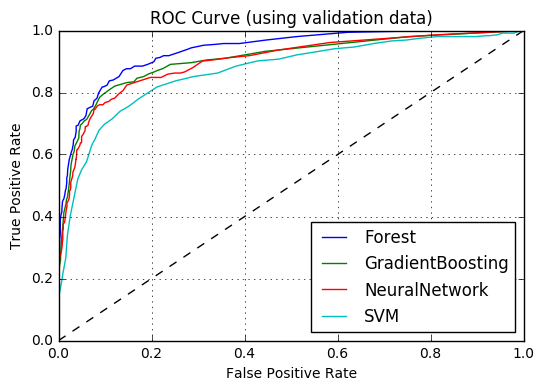

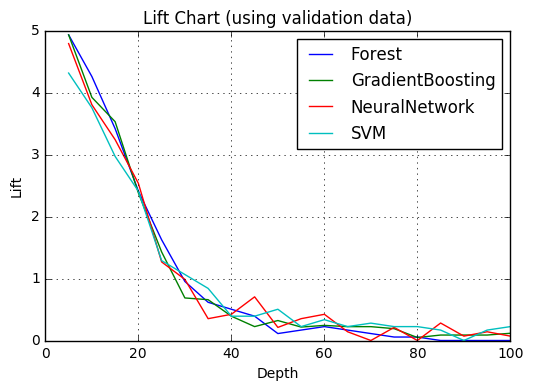

In [18]:
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()

### End CAS session

In [19]:
sess.close()